In [ ]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=17722963c2df49564b3e8e6d1668d11d3ec554823d10702f535b3e97d351bbe8
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import missingno as msno
import pandas_ta as ta

In [ ]:
microsoft_df=pd.read_csv('/content/Microsoft_weekly.csv', sep=',', header=0)
microsoft_df['Date'] = pd.to_datetime(microsoft_df.Date)


from sklearn.preprocessing import StandardScaler, MinMaxScaler

#scaler
scaler = StandardScaler()
scaler2 = MinMaxScaler()

#standardization of the prices
microsoft_df[['Close', 'Open', 'Low', 'High']] = scaler.fit_transform(microsoft_df[['Close', 'Open', 'Low', 'High']])
microsoft_df.loc[microsoft_df['Volume']>0, ['Volume']] = scaler2.fit_transform(microsoft_df.loc[microsoft_df['Volume']>0, ['Volume']])

In [ ]:
#hurst coefficient of the time series
def hurst(ts):

    n = len(ts)
    max_window = int(n / 2)
    window_sizes = range(10, max_window)
    R_S = np.zeros(len(window_sizes))

    for i, window_size in enumerate(window_sizes):
        window_ranges = np.arange(0, n, window_size)
        R, S = 0, 0
        for j in window_ranges:
            if j + window_size < n:
                # Calculate the range and standard deviation
                window = ts[j:j+window_size]
                R += np.max(window) - np.min(window)
                S += np.std(window)

        # Calculate the rescaled range
        R_S[i] = R / S

    # Fit a linear line to log-log plot
    fit = np.polyfit(np.log(window_sizes), np.log(R_S), 1)

    # Hurst exponent is the slope of the line
    hurst_exponent = fit[0]

    return hurst_exponent


ts = microsoft_df['Close']
print("Hurst Exponent for Close:", hurst(ts))

microsoft_df['log return'] = np.log(microsoft_df['Close'].shift(-1)/microsoft_df['Close'])
ts1 = microsoft_df['log return']
print("Hurst Exponent for Log return:", hurst(ts1))

microsoft_df['return'] = microsoft_df['Close'].shift(-1)/microsoft_df['Close']
ts2 = microsoft_df['return']
print("Hurst Exponent for return:", hurst(ts2))

Hurst Exponent for Close: 0.053423101570935196


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Hurst Exponent for Log return: 0.44399668360170763
Hurst Exponent for return: 0.4890441789075587


## PRIMA ARCHITETTURA

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

def LSTM_model(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],1))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense (Dense)               (None, 5, 1)              51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
47/47 [==============================] - 31s 124ms/step - loss: 0.2683 - val_loss: 9.1503
Epoch 2/10
47/47 [==============================] - 1s 20ms/step - loss: 0.2562 - val_loss: 8.2989
Epoch 3/10
47/47 [==============================] - 1s 20ms/step - loss: 0.2524 - val_loss: 8.1420
Epoch 4/10
47/47 [==============================] - 2s 35ms/step - loss: 0.2506 - val_loss: 8.2188
Epoch 5/10
47/47 [==============================] - 2s 33ms/step - loss: 0.2499 - val_loss: 8.1951
Epoch 6/10
47/47 [==============================] - 1s 25ms/step - loss: 0.2495 - val_loss: 8.1540
Epoch 7/10
47/47 [==============================] - 1s 21ms/step - loss: 0.2482 - val_loss: 7.8641
Epoch 8/10
47/47 [==============================] - 1s 19ms/step - loss: 0.2497 - val_loss: 7.7616
Epoch 9/10
47/47 [==============================] - 1s 24ms/step - loss: 0.2486 - val_loss: 8.1561
Epoch 10/10
5/5 [==============================] - 2s 7ms/step


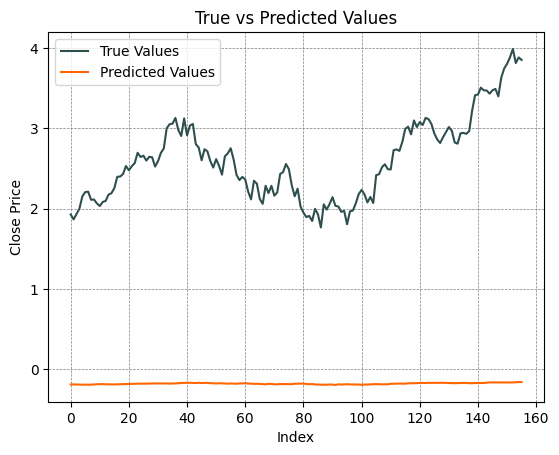

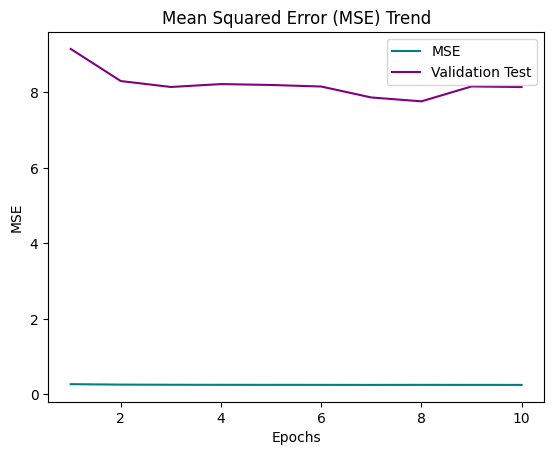

In [ ]:
#WITH 0.9 AS VALIDATION SET

splitlimit = int(len(microsoft_df) * 0.9)
microsoft_df_train_set = microsoft_df.loc[:splitlimit,:]
microsoft_df_test_set = microsoft_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=microsoft_df_train_set.shape[0]

for x in range(5, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(microsoft_df.loc[x-5:x-1,'Close'])
  y_train.append(microsoft_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, microsoft_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(microsoft_df.loc[x-5:x-1,'Close'])
  y_test.append(microsoft_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values', color='#2F4F4F')
plt.plot(y_pred[:,0],  label='Predicted Values', color='#FF6600')
plt.style.use('default')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.savefig('microsoft LTSM prices')
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values,color='#008080', label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values,color='#800080', label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## SECONDA ARCHITETTURA

In [ ]:
def LSTM_model_2(X_train, p_dropout=0.2):
  model =Sequential()
  model.add(
      LSTM(units=50,
           return_sequences=True,
           input_shape =(X_train.shape[1],4))
  )
  model.add(Dropout(p_dropout))
  model.add(LSTM(units=50,
           return_sequences=True))
  model.add(Dropout(p_dropout))

  model.add(Dense(units=1))
  return model

microsoft_df['RSI']=ta.rsi(microsoft_df.Close, length=10)
microsoft_df['EMAF']=ta.ema(microsoft_df.Close, length=20)
microsoft_df['EMAM']=ta.ema(microsoft_df.Close, length=100)

microsoft_df.head(101)


,Date,Open,High,Low,Close,Volume,RSI,EMAF,EMAM,EMAS
0,1994-03-06,-0.083026,-0.088389,-0.065915,-0.696917,0.001987,NaN,NaN,NaN,NaN
1,1994-03-13,-0.083026,-0.100173,-0.075210,-0.696732,0.000000,NaN,NaN,NaN,NaN
2,1994-03-20,-0.067892,-0.064823,-0.044228,-0.695985,0.002414,NaN,NaN,NaN,NaN
3,1994-03-27,-0.037625,-0.017690,-0.044228,-0.695297,0.009258,NaN,NaN,NaN,NaN
4,1994-04-03,-0.007359,-0.032419,-0.041130,-0.695985,0.006512,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
96,1996-01-07,-0.002819,-0.007379,-0.011697,-0.674017,0.014169,44.127085,-0.672171,NaN,NaN
97,1996-01-14,-0.019465,-0.036838,-0.073661,-0.674328,0.034361,43.283414,-0.672377,NaN,NaN
98,1996-01-21,-0.027032,0.029443,-0.048875,-0.671271,0.043718,53.061157,-0.672272,NaN,NaN
99,1996-01-28,0.042582,0.023552,0.039423,-0.671960,0.018970,50.866530,-0.672242,-0.682152,NaN


In [ ]:
microsoft_df.isna().sum()

Date        0
Open        0
High        0
Low         0
Close       0
Volume      0
RSI        10
EMAF       19
EMAM       99
EMAS      149
dtype: int64

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 50)             11000     
                                                                 
 dropout_4 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_5 (Dropout)         (None, 5, 50)             0         
                                                                 
 dense_2 (Dense)             (None, 5, 1)              51        
                                                                 
Total params: 31251 (122.07 KB)
Trainable params: 31251 (122.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Epoch 1/10
44/44 [==============================] - 7s 43ms/step - loss: 0.2869 - val_loss: 8.6327
Epoch 2/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2647 - val_loss: 8.2486
Epoch 3/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2619 - val_loss: 8.4944
Epoch 4/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2589 - val_loss: 8.4237
Epoch 5/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2586 - val_loss: 8.3602
Epoch 6/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2561 - val_loss: 8.6667
Epoch 7/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2571 - val_loss: 8.3029
Epoch 8/10
44/44 [==============================] - 0s 10ms/step - loss: 0.2591 - val_loss: 8.3446
Epoch 9/10
44/44 [==============================] - 0s 9ms/step - loss: 0.2565 - val_loss: 8.0890
Epoch 10/10
5/5 [==============================] - 1s 5ms/step


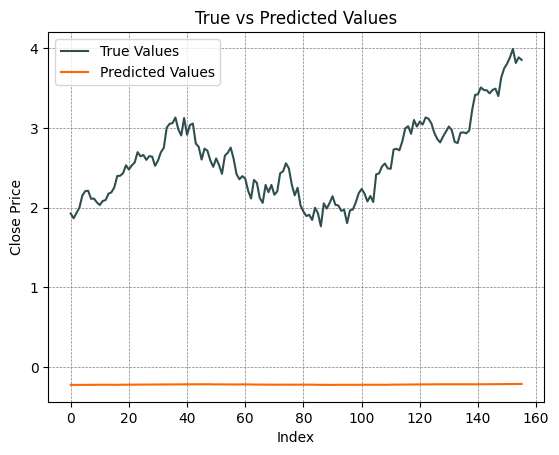

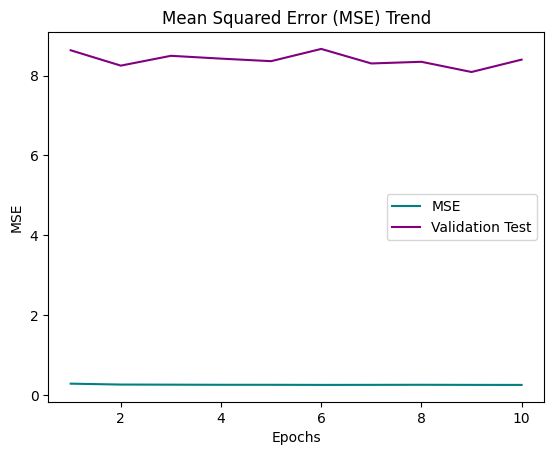

In [ ]:
#WITH 0.9 AS VALIDATION SET AND INDICATORS

splitlimit = int(len(microsoft_df) * 0.9)
microsoft_df_train_set = microsoft_df.loc[:splitlimit,:]
microsoft_df_test_set = microsoft_df.loc[splitlimit:,:]

X_train=[]
y_train =[]
df_days=microsoft_df_train_set.shape[0]

for x in range(104, df_days): #prendo intanto una finestra di 5 settimane
  X_train.append(microsoft_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM']])
  y_train.append(microsoft_df.loc[x,'Close'])

X_train,y_train = np.array(X_train), np.array(y_train)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, microsoft_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(microsoft_df.loc[x-5:x-1,['Close','RSI','EMAF','EMAM']])
  y_test.append(microsoft_df.loc[x,'Close'])

X_test,y_test = np.array(X_test), np.array(y_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

#definition
model=LSTM_model_2(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values', color='#2F4F4F')
plt.plot(y_pred[:,0],  label='Predicted Values', color='#FF6600')
plt.style.use('default')
plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.savefig('microsoft LTSM prices')
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values,color='#008080', label='MSE')
plt.plot(range(1, len(validation_values) + 1), validation_values,color='#800080', label='Validation Test')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## archietettura per log return

In [ ]:
microsoft_df['log return'] = np.log(microsoft_df['Close'].shift(-1)/microsoft_df['Close'])
microsoft_df.isna().sum()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
RSI            10
EMAF           19
EMAM           99
EMAS          149
log return      2
dtype: int64

In [ ]:
microsoft_df[microsoft_df['log return'].isna()]

,Date,Open,High,Low,Close,Volume,log return
1207,2017-04-23,-0.279276,-0.283403,-0.259366,-0.011117,0.123792,NaN
1565,2024-03-03,3.914674,3.787246,3.984779,3.853766,0.012312,NaN


In [ ]:
df_days

1410

In [ ]:
#LOG RETURN

splitlimit = int(len(microsoft_df) * 0.9)

microsoft_df['log return'] = np.log(microsoft_df['Close'].shift(-1)/microsoft_df['Close'])
microsoft_df_train_set = microsoft_df.loc[:splitlimit,:]
microsoft_df_test_set = microsoft_df.loc[splitlimit:,:]
microsoft_df.dropna(inplace=True)
X_train=[]
y_train =[]
df_days=microsoft_df_train_set.shape[0]

for x in range(5, 1206): #prendo intanto una finestra di 5 settimane ###ATTENZIONE
  X_train.append(microsoft_df.loc[x-5:x-1,'log return'])
  y_train.append(microsoft_df.loc[x,'log return'])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))


X_test=[]
y_test =[]

for x in range(df_days, microsoft_df.shape[0]): #prendo intanto una finestra di 5 settimane
  X_test.append(microsoft_df.loc[x-5:x-1,'log return'])
  y_test.append(microsoft_df.loc[x,'log return'])

X_test,y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

#definition
model=LSTM_model(X_train)
model.build()
display(model.summary())
model.compile(optimizer='adam',
              loss='mean_squared_error')

#training
history = model.fit(X_train, y_train,epochs=10, batch_size=30,validation_data= (X_test,y_test))
y_pred = model.predict(X_test)

# Plot the predicted values
plt.plot(y_test, label='True Values',  color='#2F4F4F')
plt.plot(y_pred[:,0],  label='Predicted Values', color='#FF6600')

plt.title('True vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('log return')
plt.legend()
plt.show()

# Extract the MSE values from the history object
mse_values = history.history['loss']
validation_values = history.history['val_loss']

# Plot the trend of MSE with respect to epochs
plt.plot(range(1, len(mse_values) + 1), mse_values, label='MSE', color='800080')
plt.plot(range(1, len(validation_values) + 1), validation_values, label='Validation Test', color='#008080')
plt.title('Mean Squared Error (MSE) Trend')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyError: 5